In [2]:
!pip install transformers datasets scikit-learn matplotlib seaborn pandas numpy tensorflow

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch

# Cek GPU
device_id = 0 if torch.cuda.is_available() else -1
print(f"Menggunakan Device ID: {device_id} (0=GPU, -1=CPU)")

# 1. LOAD DATA
# GANTI path ini sesuai lokasi file kamu
file_path = '/content/drive/MyDrive/one-million-reddit-confessions.csv'
df = pd.read_csv(file_path)

# 2. CLEANING
df = df[~df['selftext'].isin(['[removed]', '[deleted]'])]
df = df.dropna(subset=['title', 'selftext'])
df['clean_text'] = df['title'] + " " + df['selftext']

# Ambil sampel (5000 cukup untuk Colab gratis)
print("Mengambil sampel 10.000 data...")
df_sample = df.sample(10000, random_state=42).copy()

# 3. AUTO-LABELING EMOSI
print("Sedang mendownload model labeling...")
classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", return_all_scores=False, device=device_id)

print("Sedang melabeli data...")
# Batch processing agar hemat memori
batch_size = 32
results = []
texts = df_sample['clean_text'].tolist()

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_results = classifier(batch_texts, truncation=True, max_length=512)
    results.extend([res['label'] for res in batch_results])

df_sample['emotion_label'] = results
print("\nSelesai Labeling awal!")
print(df_sample['emotion_label'].value_counts())

Menggunakan Device ID: 0 (0=GPU, -1=CPU)


/tmp/ipython-input-713608636.py:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Mengambil sampel 10.000 data...
Sedang mendownload model labeling...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Sedang melabeli data...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Selesai Labeling awal!
emotion_label
sadness     3793
anger       2391
joy         2261
fear        1013
love         404
surprise     138
Name: count, dtype: int64


In [4]:
from sklearn.utils import resample

# Target jumlah data per emosi (agar seimbang)
target_count = 1600

print("Melakukan Balancing Data...")

# Pisahkan per emosi
dfs = {}
for emotion in df_sample['emotion_label'].unique():
    dfs[emotion] = df_sample[df_sample['emotion_label'] == emotion]

# Resampling
dfs_balanced = []
for emotion, data in dfs.items():
    df_resampled = resample(data,
                            replace=True,     # Upsampling/Downsampling
                            n_samples=target_count,
                            random_state=42)
    dfs_balanced.append(df_resampled)

# Gabung ulang
df_final = pd.concat(dfs_balanced)
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle

print("\nSebaran Data Setelah Balancing (Harus Rata):")
print(df_final['emotion_label'].value_counts())

# ENCODING & SPLIT
le = LabelEncoder()
df_final['label_encoded'] = le.fit_transform(df_final['emotion_label'])
target_names = le.classes_
num_classes = len(target_names)

X_train_txt, X_val_txt, y_train, y_val = train_test_split(
    df_final['clean_text'].values,
    df_final['label_encoded'].values,
    test_size=0.2,
    random_state=42
)

print(f"\nSiap Training! Data Train: {len(X_train_txt)}, Data Val: {len(X_val_txt)}")

Melakukan Balancing Data...

Sebaran Data Setelah Balancing (Harus Rata):
emotion_label
sadness     1600
fear        1600
surprise    1600
anger       1600
love        1600
joy         1600
Name: count, dtype: int64

Siap Training! Data Train: 7680, Data Val: 1920


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import os

# --- 1. SETUP PARAMETER ---
vocab_size = 15000     # Jumlah kosakata yang dipelajari
max_length = 150       # Panjang kalimat (cukup untuk menangkap inti konfesi)
embedding_dim = 100    # Dimensi vektor kata

# --- 2. TOKENISASI ULANG (Penting agar sinkron) ---
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_txt)

train_seq = tokenizer.texts_to_sequences(X_train_txt)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')

val_seq = tokenizer.texts_to_sequences(X_val_txt)
val_padded = pad_sequences(val_seq, maxlen=max_length, padding='post', truncating='post')

# --- 3. ARSITEKTUR LSTM YANG KUAT (Deep Learning) ---
model_lstm = Sequential([
    # Layer 1: Embedding (Mengubah kata jadi angka vektor)
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Layer 2: LSTM Pertama (Bidirectional agar baca kiri-kanan & kanan-kiri)
    # return_sequences=True wajib ada jika mau ditumpuk dengan LSTM lain
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4), # Matikan 40% neuron acak biar gak menghafal (Overfitting)

    # Layer 3: LSTM Kedua (Mengekstrak fitur lebih dalam)
    Bidirectional(LSTM(64)),
    Dropout(0.4),

    # Layer 4: Dense Layer (Otak klasifikasi)
    Dense(64, activation='relu'),
    BatchNormalization(), # Menstabilkan pembelajaran
    Dropout(0.3),

    # Layer Output: 6 Neuron untuk 6 Emosi
    Dense(num_classes, activation='softmax')
])

# --- 4. KOMPILASI & TRAINING ---
# Menggunakan optimizer Adam dengan learning rate yang diatur
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Callbacks: "Rem Otomatis" biar training berhenti di titik terbaik
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
]

print("\nMemulai Training LSTM...")
history_lstm = model_lstm.fit(
    train_padded,
    y_train,
    epochs=25, # Pasang 25, nanti berhenti sendiri kalau sudah optimal
    validation_data=(val_padded, y_val),
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# --- 5. SIMPAN MODEL ---
save_path_lstm = '/content/drive/MyDrive/Models/LSTM_Emotion'
if not os.path.exists(save_path_lstm): os.makedirs(save_path_lstm)

model_lstm.save(os.path.join(save_path_lstm, 'model_lstm.h5'))
with open(os.path.join(save_path_lstm, 'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle)

print("Model LSTM berhasil disimpan!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Memulai Training LSTM...
Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.2563 - loss: 1.7176 - val_accuracy: 0.5016 - val_loss: 1.4726 - learning_rate: 0.0010
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6046 - loss: 0.9725 - val_accuracy: 0.6302 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8045 - loss: 0.5461 - val_accuracy: 0.7031 - val_loss: 0.8296 - learning_rate: 0.0010
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9058 - loss: 0.3025 - val_accuracy: 0.7036 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9412 - loss: 0.1831 - val_accuracy: 0.7312 - val_loss: 1.0835 - learning_rate: 0.0010
Epoch 6/25
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9725 - loss: 0.0942
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - 

Model LSTM berhasil disimpan!


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_data(tokenizer, texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
    ds = Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })
    return ds

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [7]:
# Kita pakai bert-base original, lalu kita ajari emosi dari data yang sudah dilabeli tadi
model_checkpoint_bert = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_checkpoint_bert)

train_ds_bert = process_data(tokenizer_bert, X_train_txt, y_train)
val_ds_bert = process_data(tokenizer_bert, X_val_txt, y_val)

model_bert = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_bert, num_labels=num_classes).to(device)

args_bert = TrainingArguments(
    output_dir="bert_emotion_output",
    eval_strategy="epoch",      # <--- GANTI INI
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer_bert = Trainer(
    model=model_bert,
    args=args_bert,
    train_dataset=train_ds_bert,
    eval_dataset=val_ds_bert,
    compute_metrics=compute_metrics
)

print("Training BERT Emotion...")
trainer_bert.train()

save_path_bert = '/content/drive/MyDrive/Models/BERT_Emotion'
trainer_bert.save_model(save_path_bert)
tokenizer_bert.save_pretrained(save_path_bert)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT Emotion...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.822394,0.709896
2,1.254600,0.610053,0.793750
3,0.567000,0.596103,0.812500


('/content/drive/MyDrive/Models/BERT_Emotion/tokenizer_config.json',
 '/content/drive/MyDrive/Models/BERT_Emotion/special_tokens_map.json',
 '/content/drive/MyDrive/Models/BERT_Emotion/vocab.txt',
 '/content/drive/MyDrive/Models/BERT_Emotion/added_tokens.json',
 '/content/drive/MyDrive/Models/BERT_Emotion/tokenizer.json')

In [8]:
model_checkpoint_rob = "roberta-base"
tokenizer_rob = AutoTokenizer.from_pretrained(model_checkpoint_rob)

train_ds_rob = process_data(tokenizer_rob, X_train_txt, y_train)
val_ds_rob = process_data(tokenizer_rob, X_val_txt, y_val)

model_rob = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_rob, num_labels=num_classes).to(device)

args_rob = TrainingArguments(
    output_dir="roberta_emotion_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer_rob = Trainer(
    model=model_rob,
    args=args_rob,
    train_dataset=train_ds_rob,
    eval_dataset=val_ds_rob,
    compute_metrics=compute_metrics
)

print("Training RoBERTa Emotion...")
trainer_rob.train()

save_path_rob = '/content/drive/MyDrive/Models/RoBERTa_Emotion'
trainer_rob.save_model(save_path_rob)
tokenizer_rob.save_pretrained(save_path_rob)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training RoBERTa Emotion...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.125305,0.589583
2,1.608800,0.799348,0.716667
3,0.890000,0.713902,0.765625


('/content/drive/MyDrive/Models/RoBERTa_Emotion/tokenizer_config.json',
 '/content/drive/MyDrive/Models/RoBERTa_Emotion/special_tokens_map.json',
 '/content/drive/MyDrive/Models/RoBERTa_Emotion/vocab.json',
 '/content/drive/MyDrive/Models/RoBERTa_Emotion/merges.txt',
 '/content/drive/MyDrive/Models/RoBERTa_Emotion/added_tokens.json',
 '/content/drive/MyDrive/Models/RoBERTa_Emotion/tokenizer.json')

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

========== HASIL EVALUASI EMOSI: LSTM ==========
              precision    recall  f1-score   support

       anger       0.52      0.64      0.58       310
        fear       0.74      0.78      0.76       305
         joy       0.57      0.44      0.50       333
        love       0.92      0.90      0.91       304
     sadness       0.54      0.50      0.52       356
    surprise       0.96      1.00      0.98       312

    accuracy                           0.70      1920
   macro avg       0.71      0.71      0.71      1920
weighted avg       0.70      0.70      0.70      1920



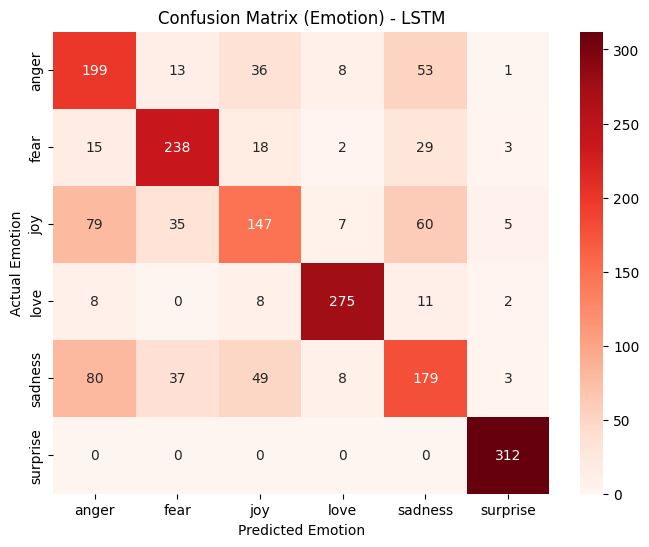


========== HASIL EVALUASI EMOSI: BERT ==========
              precision    recall  f1-score   support

       anger       0.70      0.75      0.72       310
        fear       0.79      0.89      0.84       305
         joy       0.78      0.65      0.71       333
        love       0.90      0.92      0.91       304
     sadness       0.73      0.71      0.72       356
    surprise       0.99      1.00      1.00       312

    accuracy                           0.81      1920
   macro avg       0.81      0.82      0.81      1920
weighted avg       0.81      0.81      0.81      1920



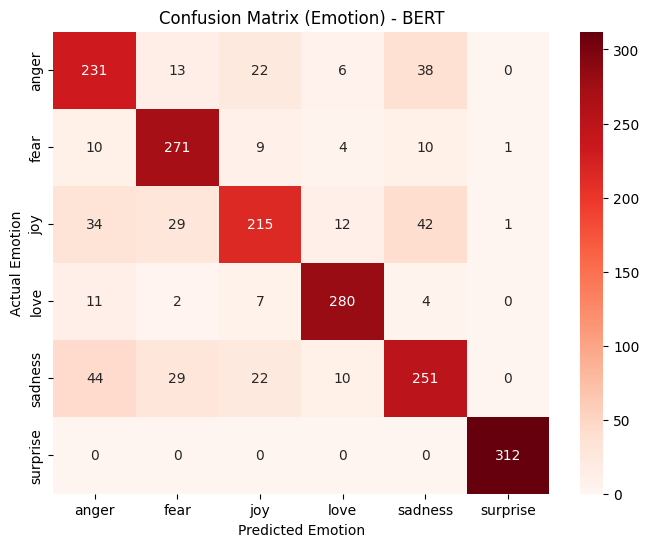


========== HASIL EVALUASI EMOSI: RoBERTa ==========
              precision    recall  f1-score   support

       anger       0.65      0.68      0.67       310
        fear       0.76      0.82      0.79       305
         joy       0.72      0.61      0.66       333
        love       0.85      0.87      0.86       304
     sadness       0.66      0.66      0.66       356
    surprise       0.97      0.98      0.98       312

    accuracy                           0.77      1920
   macro avg       0.77      0.77      0.77      1920
weighted avg       0.76      0.77      0.76      1920



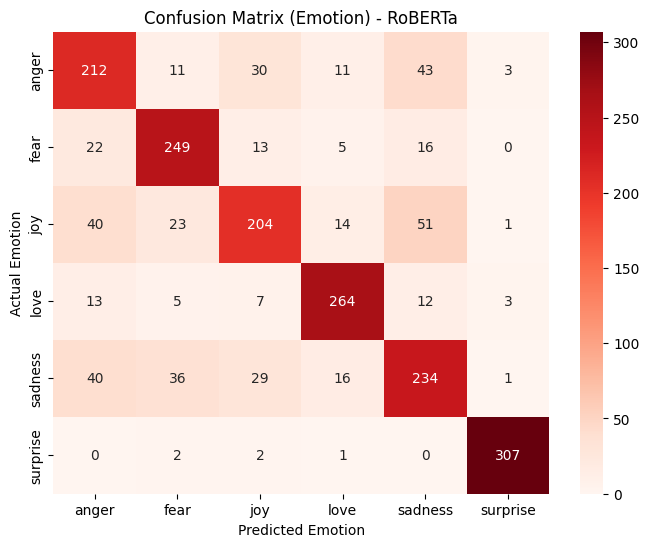

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_plot(y_true, y_pred, model_name):
    print(f"\n{'='*10} HASIL EVALUASI EMOSI: {model_name} {'='*10}")

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix (Emotion) - {model_name}')
    plt.ylabel('Actual Emotion')
    plt.xlabel('Predicted Emotion')
    plt.show()

# 1. Evaluasi RNN
y_pred_probs_lstm = model_lstm.predict(val_padded)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)
evaluate_and_plot(y_val, y_pred_lstm, "LSTM")

# 2. Evaluasi BERT
preds_bert_raw = trainer_bert.predict(val_ds_bert)
y_pred_bert = np.argmax(preds_bert_raw.predictions, axis=-1)
evaluate_and_plot(y_val, y_pred_bert, "BERT")

# 3. Evaluasi RoBERTa
preds_rob_raw = trainer_rob.predict(val_ds_rob)
y_pred_rob = np.argmax(preds_rob_raw.predictions, axis=-1)
evaluate_and_plot(y_val, y_pred_rob, "RoBERTa")